In [1]:
import os
os.system('clear')

import numpy as np
import pandas as pd

from termcolor import colored
from SecretColors.palette import Palette
material = Palette("material", color_mode = 'hexa')

# from colour import Color
hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SF Compact Text'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])

# os.chdir("./nordpool")

In [7]:
for filename in sorted(os.listdir("./raw")):
    print(filename)
    df = pd.read_excel(f"./raw/{filename}", header=[0], decimal=',', thousands='.')
    df['Date'] = pd.to_datetime(df['Instrumentcode'].str.replace("NL ID ", "").str[:7], format='%d%b%y')
    df.to_pickle(f"./{os.path.splitext(filename)[0]}.pkl")

2006_Intraday.xls
2007_Intraday.xls
2008_Intraday.xls
2009_Intraday.xls
2010_Intraday.xls
2011_Intraday.xls
2012_Intraday.xls
2013_Intraday.xls
2014_Intraday.xlsx
2015_Intraday.xlsx
2016_Intraday.xlsx
2017_Intraday.xlsx
2018_Intraday.xlsx
2019_Intraday.xlsx
~$2014_Intraday.xlsx


XLRDError: Unsupported format, or corrupt file: Expected BOF record; found b'\tTimo Vi'

findfont: Font family ['SF Compact Text'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SF Compact Text'] not found. Falling back to DejaVu Sans.


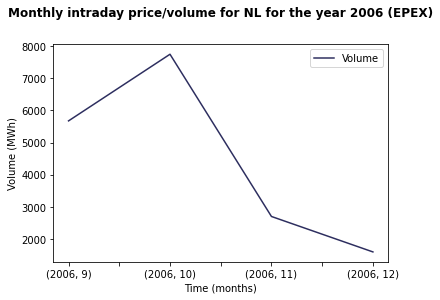

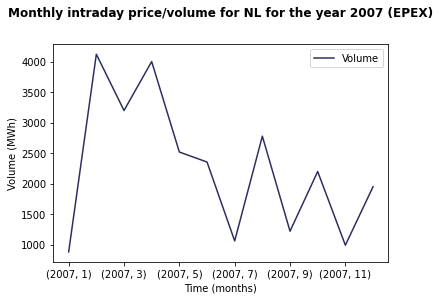

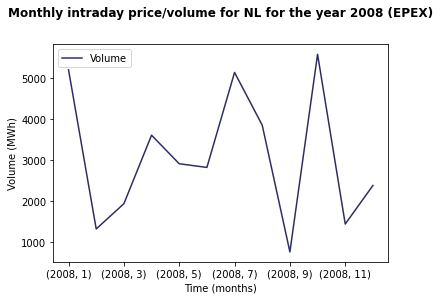

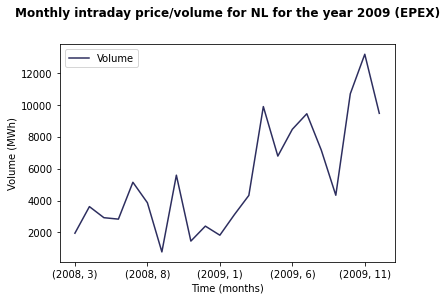

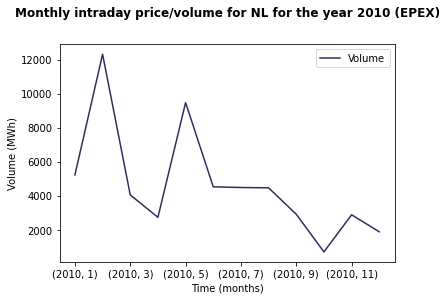

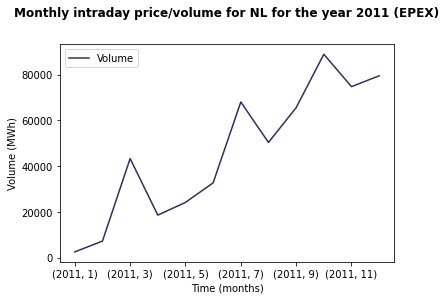

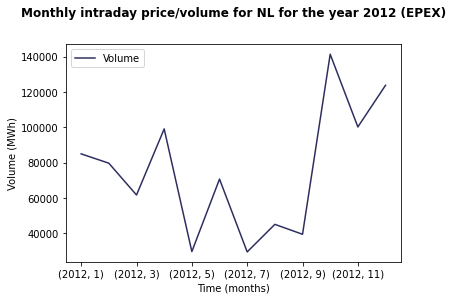

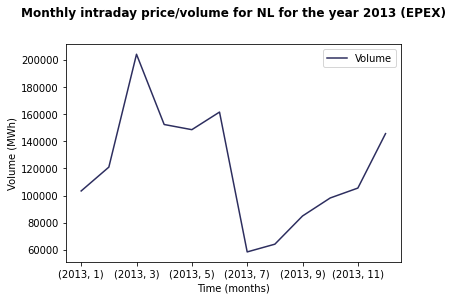

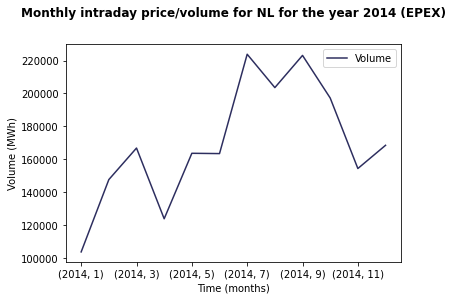

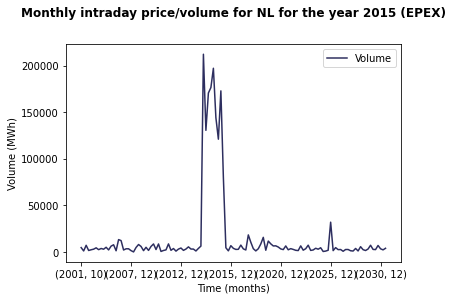

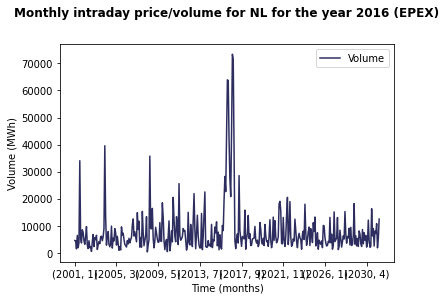

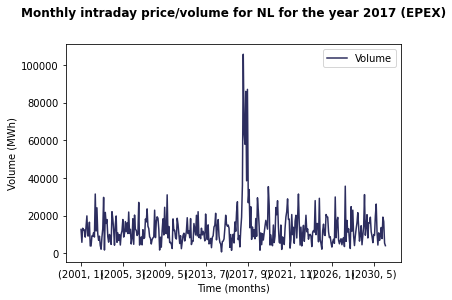

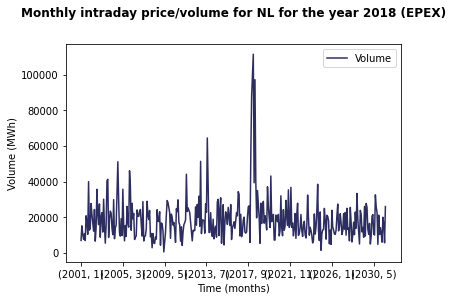

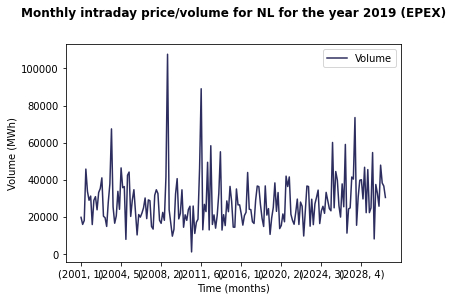

In [8]:
# years = ['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
years = ['2006']
country = 'NL'

dfo = pd.DataFrame()
buy = []
sell = []
breaks = []

for y in years:
    df = pd.read_pickle(f"./{y}_Intraday.pkl")

    volume_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Volume'].sum()
    volume_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Volume'].sum()

    price_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Price'].sum()
    price_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Price'].sum()

    df_group = df.groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()
    # df_group = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy'].groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()
    # df_group2 = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell'].groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()

    dfo = dfo.append(df_group, ignore_index = False)
    breaks.append(len(dfo))
    
    # buy.append(df['Buy'].sum())
    # sell.append(df['Sell'].sum())

    df_group[['Volume']].plot(legend=True)
    plt.title(f'Monthly intraday price/volume for {country} for the year {y} (EPEX)', y = 1.1)
    # plt.xlim(0,50)
    # plt.ylim(0, 1500)
    plt.xlabel(r'Time (months)')
    plt.ylabel(r'Volume (MWh)')
    plt.show()

    # df_group2[['Volume']].plot(legend=True)
    # plt.title(f'Monthly intraday price/volume for {country} for the year {y} (EPEX)', y = 1.1)
    # # plt.xlim(0,50)
    # # plt.ylim(0, 1500)
    # plt.xlabel(r'Time (months)')
    # plt.ylabel(r'Volume (MWh)')
    # plt.show()

In [ ]:
dfo[['Volume']].plot(legend=True)
plt.title(f'Monthly intraday volume for {country} for the period {years[0]}–{years[-1]} (Nord Pool)', y = 1.1)
# plt.xlim(0,50)
# plt.ylim(0, 1500)
plt.xlabel(r'Time (months)')
plt.ylabel(r'Volume (MWh)')
[plt.axvline(_breaks, color = hex_blue, alpha = 0.25, linewidth = 1) for _breaks in breaks]
plt.show()